In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from sklearn.decomposition import PCA
from scipy.stats import kde
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
from scipy.stats import sem 


# Load in Calibration data and last preprocessing steps

In [4]:
random.seed(10)

In [5]:
calibration_data = pd.read_csv("R 2 sigurd/PCA_CALIBRATION_2.csv")

In [6]:
#Select the right columns for our X-matrix and y vector with labels. 
X_pd_data = calibration_data.iloc[:,4:406]


X = calibration_data.iloc[:,4:406].values
y = calibration_data.iloc[:,406].values

#Standardize
sc = StandardScaler()
X_std = sc.fit_transform(X)

# Y as numeric
y_2 = np.zeros(shape = len(y))
for i in range(len(y)):
    if y[i] == "Central": #Central = STRAIGHT = NOT DEVIATED / CONTROL
        y_2[i] = 0
    else: 
        y_2[i] = 1


In [7]:
#PCA
pca_model = PCA(n_components= 13)
pca_model.fit(X_std)
X_pca = pca_model.transform(X_std)

# VALIDATING R-studio results in Python using calibration/validation data. 

First we will calculate mean AUC scores across cross validation. 

#### Cross-val with different n-PCA features. 

In [11]:
#Function for stratified k-fold with different number of PCA features. 

def n_pca_try(X, y, max_n): 
    lda = LinearDiscriminantAnalysis()
    n_feat = []
    for i in range(2,max_n):
        pca_model = PCA(n_components= i)
        sc = StandardScaler()
        kf = StratifiedKFold(n_splits= 10 , shuffle= True)

        roc_scores_list = []
        for train, test in kf.split(X, y):
            #std
            X_train_std = sc.fit_transform(X[train,])
            X_test_std = sc.transform(X[test,])
            #Pca 
            X_train_pca = pca_model.fit_transform(X_train_std)
            X_test_pca = pca_model.transform(X_test_std)
            #Lda
            lda.fit(X_train_pca, y[train])
            y_score_lda1 = lda.decision_function(X_test_pca)
            roc_scores_list.append(roc_auc_score(y[test], y_score_lda1))
        
        n_feat.append(np.mean(roc_scores_list))

    return n_feat 


In [46]:
#FUll model only
AUC_DIFF_PCA = n_pca_try(X, y_2, 99)

<function matplotlib.pyplot.show(close=None, block=None)>

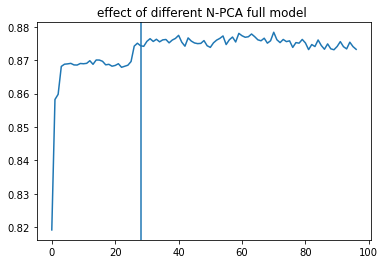

In [47]:
plt.plot(AUC_DIFF_PCA)
plt.axvline(28)
plt.title("effect of different N-PCA full model ")
plt.show

## Test different Number of pca features on Velocity, Acceleration and coordinates.



In [35]:
#get index
#Vel
indx_start_vel = X_pd_data.columns.get_loc('v002') 
indx_end_vel = X_pd_data.columns.get_loc('v101')
#acc
indx_start_acc = X_pd_data.columns.get_loc('a002') 
indx_end_acc = X_pd_data.columns.get_loc('a101')
#Coord
indx_start_coord = X_pd_data.columns.get_loc('x001') 
indx_end_coord = X_pd_data.columns.get_loc('y101')


#get X_vel X_acc and Coord
X_vel = X[:, indx_start_vel:indx_end_vel] 
X_acc = X[:, indx_start_acc:indx_end_acc]
X_coord = X[:, indx_start_coord:indx_end_coord]

#VEl ACC
X_vel_acc = np.concatenate((X_vel,X_acc),axis=1)
#Coord vel
X_coord_vel = np.concatenate((X_coord, X_vel), axis = 1)

In [49]:
#Get effect of n principal components for each type of LDA. 
n_pca_vel = n_pca_try(X_vel, y_2, 99)
n_pca_acc = n_pca_try(X_acc, y_2, 99)
n_pca_coord = n_pca_try(X_coord,y_2 , 99)
n_pca_vel_acc = n_pca_try(X_vel_acc, y_2 , 99)




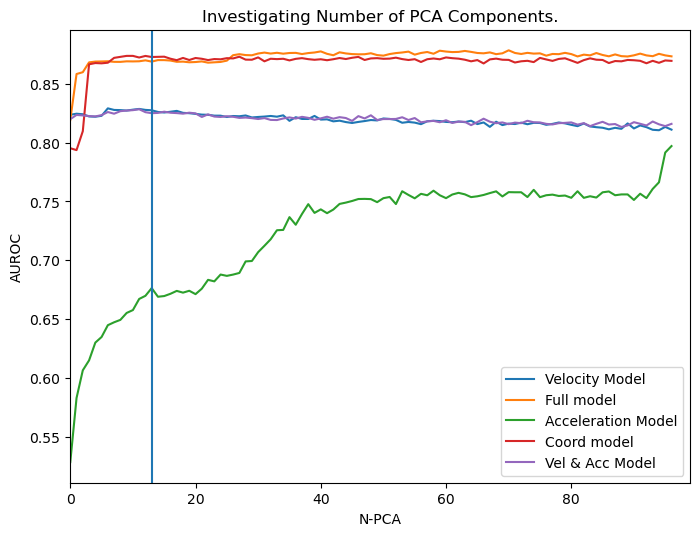

In [50]:
#Plot all the model with varying principal components. 

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(n_pca_vel, label = "Velocity Model")
plt.plot(AUC_DIFF_PCA, label = "Full model")
plt.plot(n_pca_acc, label = "Acceleration Model")
plt.plot(n_pca_coord, label = "Coord model")
plt.plot(n_pca_vel_acc, label = "Vel & Acc Model")

plt.axvline(13)
plt.xlim(0, 99)
plt.xlabel("N-PCA")
plt.ylabel("AUROC")
plt.title("Investigating Number of PCA Components.")
plt.legend()
plt.savefig("PCA_FIGURE.png", dpi = 1000)
plt.show()

### Stopping Rule of 95% variance for PCA. 

In [51]:
#Function for testing n principal components but now with stopping rule of 95% variance contained. 
def n_pca_try2(X, y): 
    lda = LinearDiscriminantAnalysis()
 
   
    pca_model = PCA(n_components= 0.95)
    sc = StandardScaler()
    kf = StratifiedKFold(n_splits= 10 , shuffle= True)

    roc_scores_list = []


    for train, test in kf.split(X, y):
        
        #std
        X_train_std = sc.fit_transform(X[train,])
        X_test_std = sc.transform(X[test,])
        #Pca 
        X_train_pca = pca_model.fit_transform(X_train_std)
        X_test_pca = pca_model.transform(X_test_std)
        #Lda
        lda.fit(X_train_pca, y[train])
        y_score_lda1 = lda.decision_function(X_test_pca)
        roc_scores_list.append(roc_auc_score(y[test], y_score_lda1))
    

        y_list = np.cumsum(pca_model.explained_variance_ratio_)

    return roc_scores_list, y_list



In [52]:
# var_pca... = a vector with proportional variance for each number of principal component
# n_pca... = AUROC score. 

n_pca_full2, var_pca_full = n_pca_try2(X, y_2)
n_pca_vel2, var_pca_vel = n_pca_try2(X_vel, y_2)
n_pca_acc2, var_pca_acc = n_pca_try2(X_acc, y_2)
n_pca_coord2, var_pca_coord2 = n_pca_try2(X_coord,y_2)
n_pca_vel_acc2, var_pca_vel_acc = n_pca_try2(X_vel_acc, y_2)


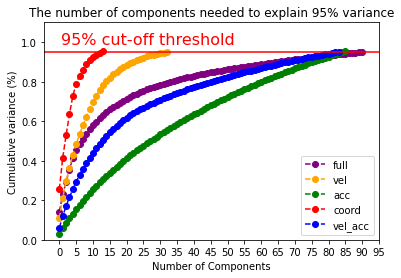

In [53]:
#Plot the Cumulative variance in % 
plt.plot(var_pca_full, marker='o', linestyle='--', label = "full", color = "purple")
plt.plot(var_pca_vel, marker='o', linestyle='--', label = "vel", color = "orange")
plt.plot(var_pca_acc, marker='o', linestyle='--', label = "acc",  color = "g")
plt.plot(var_pca_coord2, marker='o', linestyle='--', label = "coord", color = "red")
plt.plot(var_pca_vel_acc, marker='o', linestyle='--', label =  "vel_acc", color = "blue")

plt.xlabel('Number of Components')
plt.legend()
plt.xticks(np.arange(0, 100, step=5))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain 95% variance')
plt.ylim(0.0,1.1)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.99, '95% cut-off threshold', color = 'red', fontsize=16)
plt.savefig("95% variance cutoff.png", dpi = 200)

plt.show()

In [54]:
#Get a data frame with the average performance of AUROC.
dict_pca  = {"acc": n_pca_acc2, "coord": n_pca_coord2, "vel_acc": n_pca_vel_acc2, "vel":n_pca_vel2, "full":n_pca_full2}

n_pca_df_ALL = pd.DataFrame({"number of PCA": [var_pca_acc.size, var_pca_coord2.size, var_pca_vel_acc.size, var_pca_vel.size , var_pca_full.size],
    "model": ["Acc", "Coord", "Vel and Acc", "Vel", "Full"],
    "Mean AUROC": [np.mean(dict_pca[f]) for f in dict_pca.keys()],
    "Upper Conf": [np.mean(dict_pca[f]) + sem(dict_pca[f]) * 1.96 for f in dict_pca.keys()],
    "Lower Conf": [np.mean(dict_pca[f]) - sem(dict_pca[f]) * 1.96 for f in dict_pca.keys()],
    "keys": dict_pca.keys()
    })
n_pca_df_ALL
    

,number of PCA,model,Mean AUROC,Upper Conf,Lower Conf,keys
0,86,Acc,0.755168,0.779460,0.730877,acc
1,14,Coord,0.873365,0.886329,0.860402,coord
2,84,Vel and Acc,0.816706,0.835316,0.798096,vel_acc
3,33,Vel,0.821200,0.836347,0.806054,vel
4,91,Full,0.872739,0.883061,0.862418,full


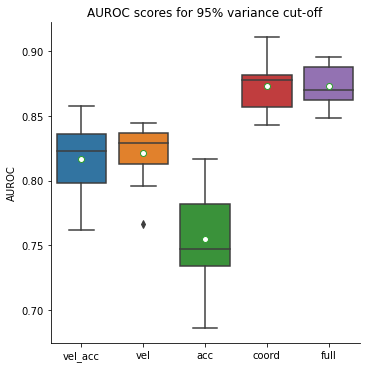

In [55]:
#plot average AUROC score for the 10 fold cross-validation. 
n_pca_df = pd.DataFrame({
    "vel_acc": n_pca_vel_acc2,
    "vel": n_pca_vel2,
    "acc": n_pca_acc2,
    "coord": n_pca_coord2,
    "full": n_pca_full2 })



sns.catplot(data = n_pca_df, kind= "box", showmeans = True, meanprops = {"marker": "o", "markerfacecolor": "white"})
plt.tight_layout()
plt.ylabel("AUROC")
plt.title("AUROC scores for 95% variance cut-off")
plt.savefig("AUROC_score_95 cut off.png", bbox_inches = "tight") #bbox_inhces = "tight"  allows for labels and titles to be in the saved file. 

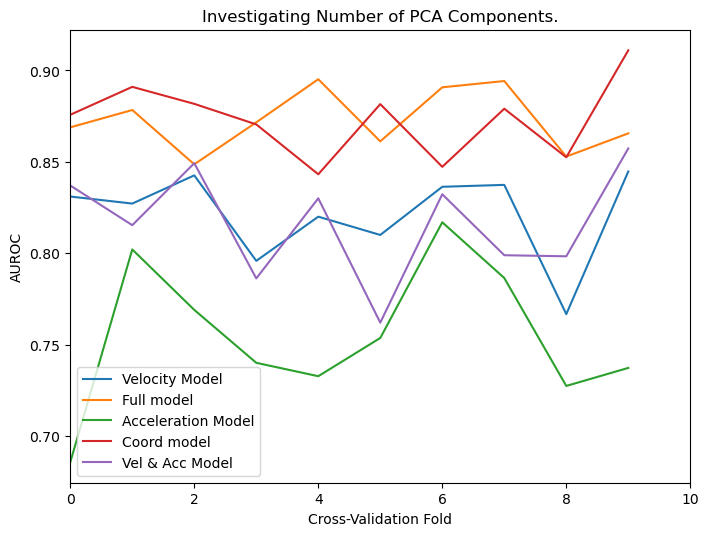

In [56]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(n_pca_vel2, label = "Velocity Model")
plt.plot(n_pca_full2, label = "Full model")
plt.plot(n_pca_acc2, label = "Acceleration Model")
plt.plot(n_pca_coord2, label = "Coord model")
plt.plot(n_pca_vel_acc2, label = "Vel & Acc Model")

plt.axvline(13)
plt.xlim(0, 10)
plt.xlabel("Cross-Validation Fold")
plt.ylabel("AUROC")
plt.title("Investigating Number of PCA Components.")
plt.legend()
#plt.savefig("PCA_FIGURE_0_95.png", dpi = 1000)
plt.show()

## Showing that using Python isn't a cause for interference. 

In [57]:
def CV_train(n_compon, data, labels):
    sc = StandardScaler()
    pc = PCA(n_components= n_compon)

    lda = LinearDiscriminantAnalysis()
    kf = StratifiedKFold(n_splits= 10 , shuffle= True)

    #lists
    roc_scores_list = []
    
    for train, test in kf.split(data, labels):
        #std 
        data_std_train = sc.fit_transform(data[train]) 
        data_std_test = sc.transform(data[test])
        
        #PCA
        data_pca_train = pc.fit_transform(data_std_train)
        data_pca_test = pc.transform(data_std_test)

        lda.fit(data_pca_train, labels[train])
        y_score_lda1 = lda.decision_function(data_pca_test)
        roc_scores_list.append(roc_auc_score(labels[test], y_score_lda1))
    return roc_scores_list



Replicate their LDA models on calibration data. 

In [58]:
data_frame_CV_model_calibration = pd.DataFrame({
        "CV Iteration": range(1,11),
        "full_model": CV_train(n_compon= 13, data= X, labels = y_2),
        "coord_model": CV_train(n_compon= 13, data = X_coord, labels = y_2),
        "vel_model": CV_train(n_compon= 13, data= X_vel, labels= y_2),
        "acc_model": CV_train(n_compon= 13, data = X_acc, labels = y_2),
        "vel acc model": CV_train(n_compon= 13, data = X_vel_acc, labels = y_2),
        "coord vel model": CV_train(n_compon= 13, data = X_coord_vel, labels = y_2)  })


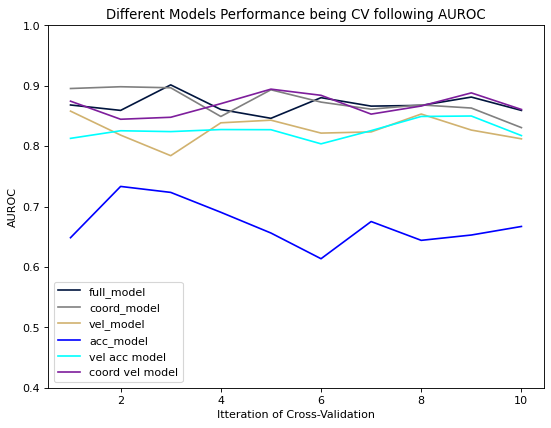

In [59]:
#plot The AUROC from the cross-validation test. 
from scipy.interpolate import make_interp_spline, BSpline

#colors
colors = ["OK","#01153E", "#808080", "#D1B26F", "#0000FF","#00FFFF", "#7E1E9C"]

plt.figure(figsize=(8, 6), dpi=80)
for i in range(1,7):
    x_new = np.linspace(data_frame_CV_model_calibration.iloc[:,0].min(), data_frame_CV_model_calibration.iloc[:,0].max(), 10)
    y = data_frame_CV_model_calibration.iloc[:,i]

    spl = make_interp_spline(data_frame_CV_model_calibration.iloc[:,0], y, k = 2)
    y_smooth = spl(x_new)
    
    plt.plot(x_new, y_smooth, label = data_frame_CV_model_calibration.columns[i], color = colors[i])

plt.title("Different Models Performance being CV following AUROC")
plt.ylabel("AUROC")
plt.xlabel("Itteration of Cross-Validation")
plt.ylim(0.4, 1)
plt.legend()
plt.savefig('cross_val_different_models.png', dpi  = 1000)
plt.show()

## Create the ROC curve 

Creating ROC curves for validation/calibration data with all features included. 

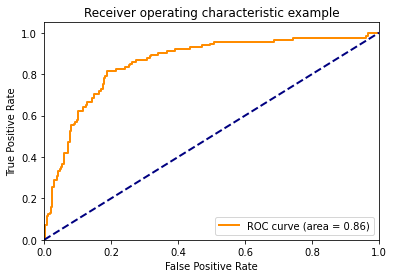

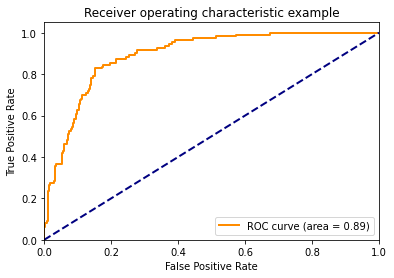

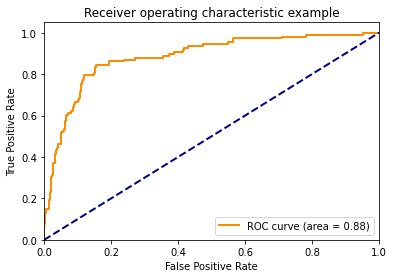

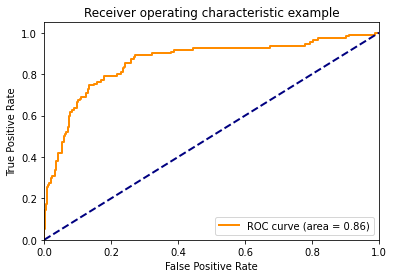

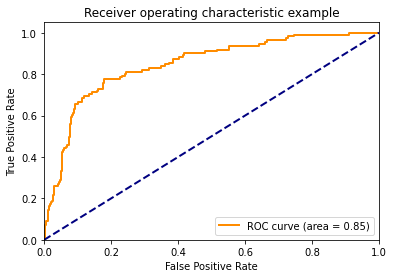

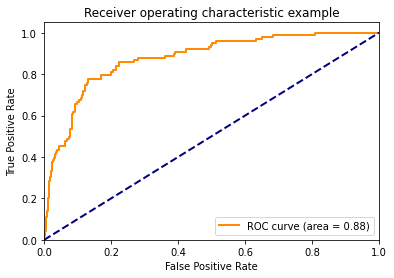

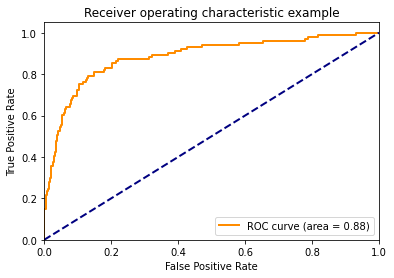

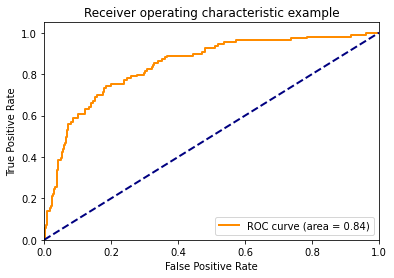

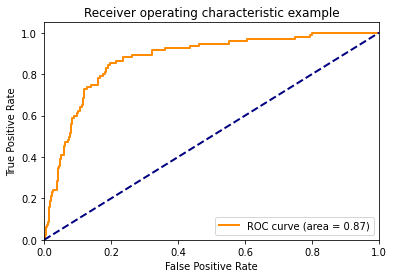

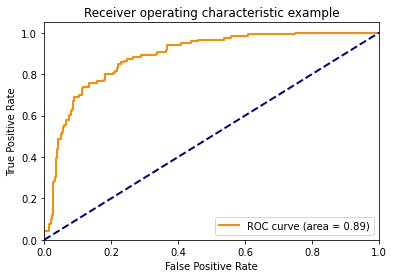

In [60]:

lda = LinearDiscriminantAnalysis()
kf = KFold(n_splits= 10, shuffle= True)

for train, test in kf.split(X_pca):
    lda.fit(X_pca[train,:], y_2[train])
    y_score_lda1 = lda.decision_function(X_pca[test,:])
    fpr, tpr, _ = roc_curve(y_2[test], y_score_lda1)
    roc_auc = auc(fpr, tpr)
    

    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,
        color="darkorange",lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

# Investigating Negation data.
Load in negation data and preprocess it

In [68]:
negation_data = pd.read_csv("R 2 sigurd/Sigurd_Negation_PCA_data.csv")
#filter for true
negation_data_true = negation_data[negation_data["Response"] == True]


In [72]:
#Get X
negation_X_start = negation_data_true.columns.get_loc('x001') 
X_negation_true = negation_data_true.iloc[:,negation_X_start:410].values


#std
sc = StandardScaler()
sc.fit(X)
X_negation_std = sc.transform(X_negation_true)

#pca 
pca_model = PCA(n_components= 13)
pca_model.fit(X_std)
X_negation_pca = pca_model.transform(X_negation_std)


#Get Y
Y_negation_true = negation_data_true.iloc[:,3].values

#turn y numeric 0 = Not deviated,  1 = deviated. 
y_negation_true_2 = np.zeros(shape = len(Y_negation_true))
for i in range(len(Y_negation_true)):
    if Y_negation_true[i] == "P": #Central = STRAIGHT = NOT DEVIATED / CONTROL
        y_negation_true_2[i] = 0
    else: 
        y_negation_true_2[i] = 1

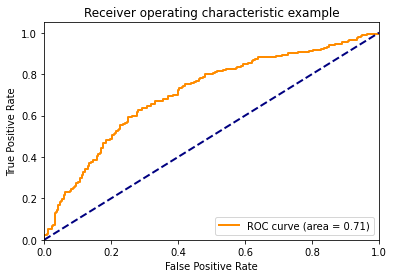

0.7074660633484163


In [73]:
## Getting ROC curve for negation full LDA model. 

lda = LinearDiscriminantAnalysis()

lda.fit(X_pca, y_2)
y_score_lda1 = lda.decision_function(X_negation_pca)
fpr, tpr, _ = roc_curve(y_negation_true_2, y_score_lda1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr,tpr,
    color="darkorange",lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

#AUC SCORE for ROC curve
print(roc_auc_score(y_negation_true_2, y_score_lda1))

# Our Analysis on Spivey data
## **Testing their lda and pca model on our spivey replication data.** 

In [14]:
#Load data and prepare

spivey_data = pd.read_csv("R 2 sigurd/spivey_data_for_pca.csv") 


#X
X_spivey = spivey_data.iloc[:,4:407] #Only containing Coordinates, Velocity and Acceleration. 
X_spivey['a101'] = 0 #Turn NA's into 0. 
X_spivey_ndarray = X_spivey.values #ndarray. 


#std
sc = StandardScaler()
sc.fit(X) 
X_spivey_std = sc.transform(X_spivey)

#pca 
pca_model = PCA(n_components= 13) # Continuning with 13 Principal components as selected by Maldonato et al., (2019). Look at earlier section of PCA on Calibration for our investigation on PCA. 
pca_model.fit(X_std)
X_spivey_pca = pca_model.transform(X_spivey_std)



In [15]:
#Y find Polarity. 
y_spivey = spivey_data.iloc[:,2]
#Prepare array.
y_spivey2 = np.zeros(shape = len(y_spivey))

# Y as numeric. 1 = devitation/cohort,   0 = No Deviation/Control
for i in range(len(y_spivey)):
    if y_spivey[i] == "cohort":
        y_spivey2[i] = 1
    else: 
        y_spivey2[i] = 0

np.unique(y_spivey, return_counts= True) #Slightly more Control than cohort. - Wrong anwers have been filtered and people are more likely to answer incorrectly on Conhort. 

(array(['cohort', 'control'], dtype=object), array([436, 446]))

## First a glance into the data and model. 

In [16]:
# LDA Fit on Calibration test on Spivey

#fit 
lda = LinearDiscriminantAnalysis()
lda.fit(X_pca, y_2)

#predict on Spivey data 
lda.predict(X_spivey_pca)
lda.score(X_spivey_pca, y_spivey2)



#get lda values. 
spivey_data["lda_value"] = lda.transform(X_spivey_pca)


In [17]:
predict_list = lda.predict(X_spivey_pca)

np.unique(predict_list, return_counts= True) #859 predicted as Control,   23 Predicted as Cohort. 


(array([0., 1.]), array([859,  23]))

In [18]:
# Find mean lda_value with se for both Polarities. 
from scipy.stats import sem

d = {'means': [spivey_data.loc[spivey_data["Polarity"] == "control", "lda_value"].mean(), spivey_data.loc[spivey_data["Polarity"] != "control", "lda_value"].mean()], 
    "se": [sem(spivey_data.loc[spivey_data["Polarity"] == "control", "lda_value"]) ,sem(spivey_data.loc[spivey_data["Polarity"] != "control", "lda_value"])] }

pd.DataFrame(data = d)


,means,se
0,-3.495437,0.067193
1,-3.073958,0.086275


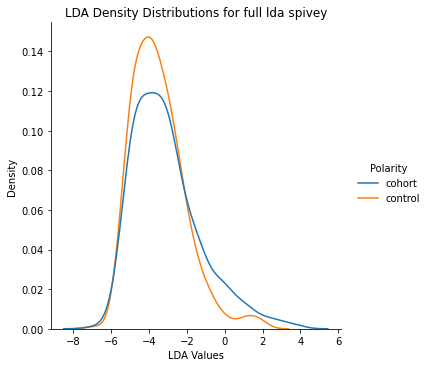

In [19]:
#sns.set_style('whitegrid')
p = sns.displot(spivey_data, x = "lda_value", hue = "Polarity", kind = "kde")
p.set( xlabel = "LDA Values", ylabel = "Density", title = "LDA Density Distributions for full lda spivey")

In [20]:
y_score_lda = lda.fit(X_pca, y_2).decision_function(X_spivey_pca) #fit on validation data # test on Spivey data
roc_auc_score(y_spivey2, y_score_lda)

0.5584399555683548

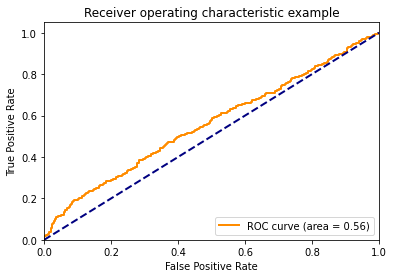

In [21]:
# ROC for Full lda. 
lda = LinearDiscriminantAnalysis()

lda.fit(X_pca, y_2)
y_score_lda1 = lda.decision_function(X_spivey_pca)
fpr, tpr, _ = roc_curve(y_spivey2, y_score_lda1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr,tpr,
    color="darkorange",lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## How does different feature combinations perform on our model. 
Fitted and tested on our own data.


 1. First we subset data into Coordinates, Velocity, Acceleration etc. 
 2. Test how the number of PCA effects 
 3. Do our real analysis of training on Calibration and testing on bootstrapped Spivey data as well as topline, baseline and alternative measures. 

In [32]:
#get index
#Vel
indx_start_vel = spivey_data.columns.get_loc('v002') 
indx_end_vel = spivey_data.columns.get_loc('v101')
#acc
indx_start_acc = spivey_data.columns.get_loc('a002') 
indx_end_acc = spivey_data.columns.get_loc('a101')
#Coord
indx_start_coord = spivey_data.columns.get_loc('x001') 
indx_end_coord = spivey_data.columns.get_loc('y101')


#get X_vel X_acc and Coord
X_vel_spivey = spivey_data.iloc[:, indx_start_vel:indx_end_vel].values 

X_acc_spivey = spivey_data.iloc[:, indx_start_acc:indx_end_acc].values

X_coord_spivey = spivey_data.iloc[:, indx_start_coord:indx_end_coord].values

X_vel_acc_spivey = np.concatenate((X_vel_spivey,X_acc_spivey),axis=1)

### Small test of what happens if we only train Std, PCA and LDA on the Spivey data. 

In [23]:
#Different models with different number of PCA features only fitted/trained on Spivey data and tested on SPivey data. 
X_vel_acc_list = n_pca_try(X_vel_acc_spivey, y_spivey2, max_n = 80)

X_vel_list = n_pca_try(X_vel_spivey, y_spivey2, 80)

X_acc_list = n_pca_try(X_acc_spivey, y_spivey2, 80)

X_coord_list = n_pca_try(X_coord_spivey, y_spivey2, 80)

X_all_list = n_pca_try(X_spivey_ndarray, y_spivey2, 80)

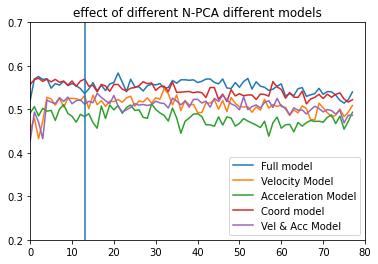

In [24]:
plt.plot(X_all_list, label = "Full model")
plt.plot(X_vel_list, label = "Velocity Model")
plt.plot(X_acc_list, label = "Acceleration Model")
plt.plot(X_coord_list, label = "Coord model")
plt.plot(X_vel_acc_list, label = "Vel & Acc Model")
plt.axvline(13)
plt.xlim(0, 80)
plt.title("effect of different N-PCA different models")
plt.legend()
plt.ylim(0.20,0.70)
plt.show()

### Now we train on Calibration data and Test on Spivey data. 

In [25]:
#Function for testing different X feature matrixes. 

def train_test(n_compon, data_train , data_test, y_train, y_test):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    lda = LinearDiscriminantAnalysis()

    #Standardize
    train_sc = sc.fit_transform(data_train)
    test_sc = sc.transform(data_test)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
    test_pc = pc.transform(test_sc)


    #lda
    lda.fit(train_pc, y_train)
    lda_score_y_test = lda.decision_function(test_pc)
    fpr, tpr, _  = roc_curve(y_test , lda_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score


train_test(n_compon= 13, data_train= X, data_test= X_spivey, y_train= y_2, y_test= y_spivey2)

0.5584605257744683

In [26]:
spivey_all_measures = pd.read_csv("R 2 sigurd/spivey_data_for_python.csv")

spivey_all_measures.describe()


,Subject,Item.number,x001,x002,x003,x004,x005,x006,x007,x008,...,MD_below_time,AD,AUC,xpos_flips,ypos_flips,xpos_reversals,ypos_reversals,RT,initiation_time,idle_time
count,882.000000,882.000000,8.820000e+02,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,...,882.00000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.0,882.000000
mean,61.776644,31.614512,-7.707405e-01,-0.772358,-0.769177,-0.768671,-0.767188,-0.766196,-0.764298,-0.761915,...,397.26093,27.913727,27067.073641,1.519274,0.938776,0.685941,1.024943,845.774376,0.0,242.837744
std,35.893571,18.461388,2.221706e-16,0.077075,0.042200,0.049642,0.065535,0.086106,0.106483,0.127349,...,358.03459,63.973293,60101.458070,1.308391,1.160597,0.766795,0.222082,360.428192,0.0,244.604191
min,4.000000,0.000000,-7.707405e-01,-2.520231,-1.082218,-1.143242,-1.357933,-1.741399,-2.029255,-2.255238,...,0.00000,-171.671923,-159849.864638,0.000000,0.000000,0.000000,1.000000,205.000000,0.0,0.000000
25%,22.000000,16.000000,-7.707405e-01,-0.773263,-0.775670,-0.776278,-0.776708,-0.777186,-0.777335,-0.777659,...,79.17000,-6.238178,-7384.069181,1.000000,0.000000,0.000000,1.000000,550.250000,0.0,43.260000
50%,61.500000,32.000000,-7.707405e-01,-0.770740,-0.770740,-0.770740,-0.770740,-0.770740,-0.770740,-0.770740,...,311.67000,8.237890,10591.908516,1.000000,1.000000,1.000000,1.000000,809.000000,0.0,158.560000
75%,99.000000,48.000000,-7.707405e-01,-0.767674,-0.765376,-0.764364,-0.761981,-0.758616,-0.752948,-0.747106,...,642.55000,41.033982,44923.712760,2.000000,2.000000,1.000000,1.000000,1079.750000,0.0,387.952500
max,107.000000,63.000000,-7.707405e-01,0.112061,0.112061,0.112061,0.112061,0.293458,0.484569,0.568784,...,1849.00000,366.668499,388829.647392,7.000000,7.000000,5.000000,3.000000,2413.000000,0.0,1462.000000


In [27]:
# Function for AUROC for measures such as AUC, Maximum Deviation etc. 
def alternative_measures(measure, data, labels):
    sc = StandardScaler()

    data_std = sc.fit_transform(data.loc[:,[measure]])


    fpr, tpr, _ = roc_curve(labels, data_std)
    roc_auc = auc(fpr,tpr)
    #plot
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,
        color="darkorange",lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic for %s" %measure)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc


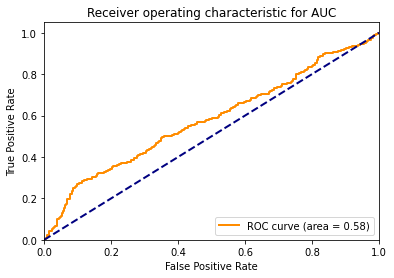

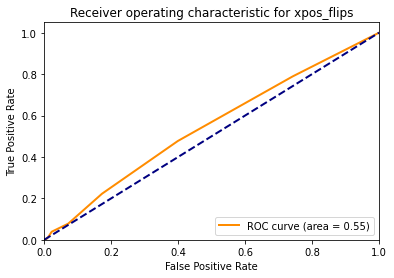

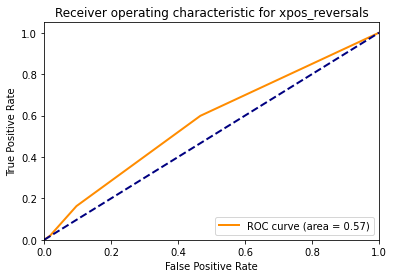

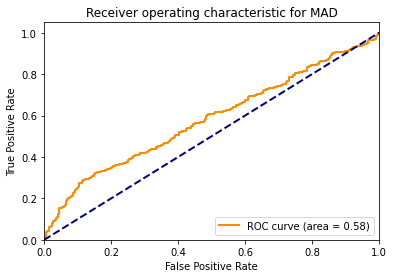

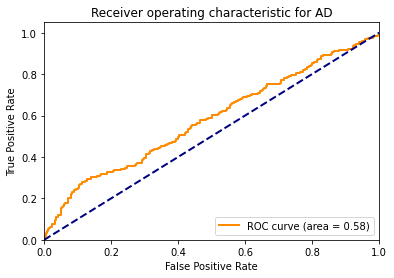

0.5800129592298515

In [103]:

alternative_measures(measure= "AUC", data = spivey_all_measures, labels= y_spivey2) #AUC 

alternative_measures(measure="xpos_flips", data = spivey_all_measures, labels= y_spivey2) #change of direction

alternative_measures(measure="xpos_reversals", data = spivey_all_measures, labels= y_spivey2) #Time it cross the y-axis. 

alternative_measures(measure="MAD", data = spivey_all_measures, labels= y_spivey2) #Maximum absouloute deviation

alternative_measures(measure= "AD",data = spivey_all_measures, labels= y_spivey2) #Average Deviation. 


In [28]:
# baseline function to simulate a stochastic process of classifyng. 

def baseline(y_list):
    y_spivey2_copy = y_list.copy()

    roc_auc_list = []

    for i in range(2500):
        np.random.shuffle(y_spivey2_copy)
        fpr, tpr, _ = roc_curve(y_list, y_spivey2_copy)
        roc_auc_list.append(auc(fpr,tpr))

    baseline_auc = np.mean(roc_auc_list)
    baseline_auc_std = np.std(roc_auc_list)
    return baseline_auc , baseline_auc_std

baseline(y_list= y_spivey2)

(0.5006441992018761, 0.016793294100157702)

In [29]:
# TOPLINE
def topline(n_compon, data_train , y_train):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    lda = LinearDiscriminantAnalysis()

    #Standardize
    train_sc = sc.fit_transform(data_train)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
  

    #lda
    lda.fit(train_pc, y_train)
    lda_score_y_test = lda.decision_function(train_pc)
    fpr, tpr, _  = roc_curve(y_train , lda_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score

topline(n_compon= 13, data_train= X_spivey, y_train= y_spivey2)

0.5961862837865636

# BOOTSTRAP TIME

6


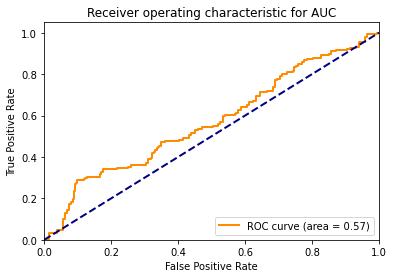

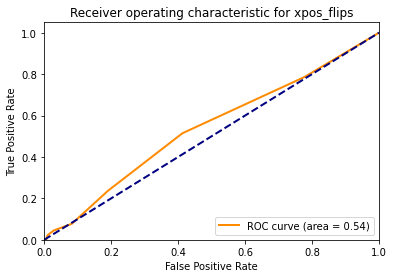

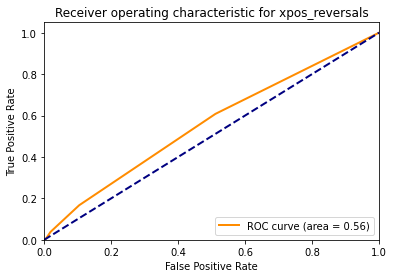

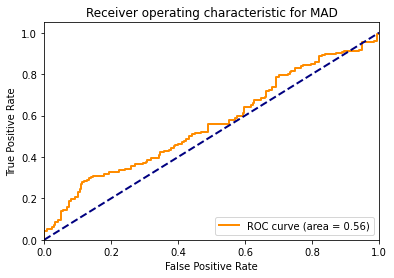

7


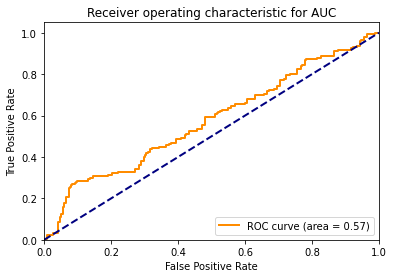

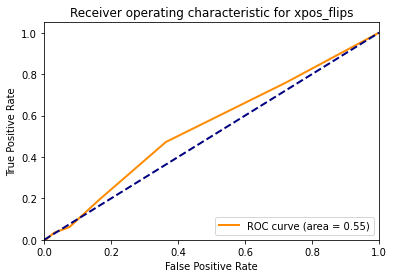

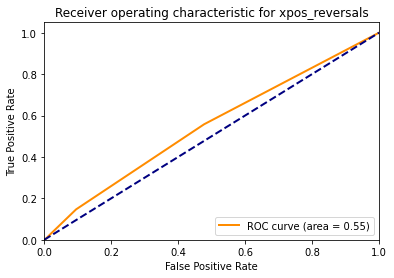

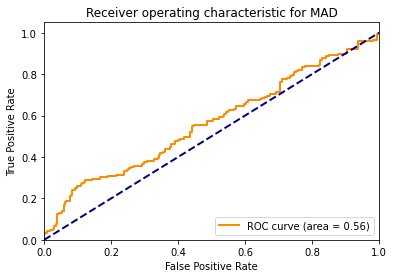

8


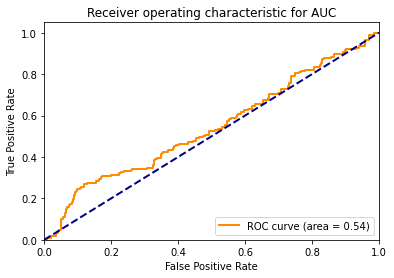

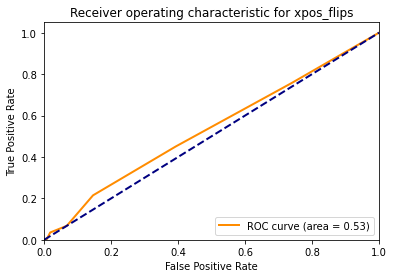

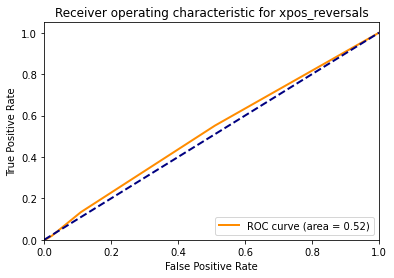

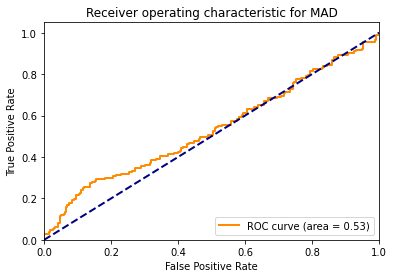

9


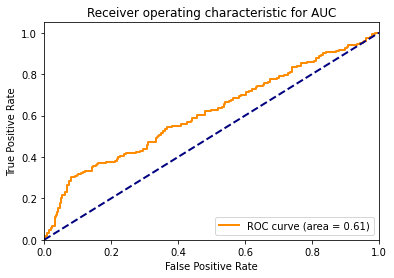

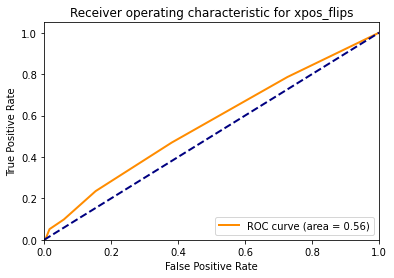

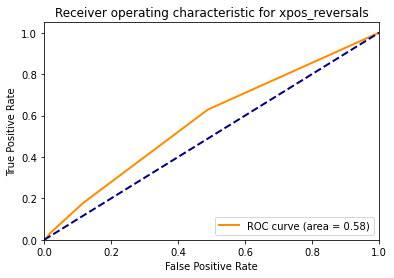

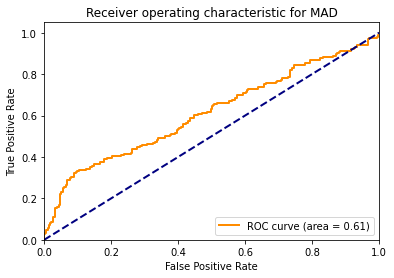

10


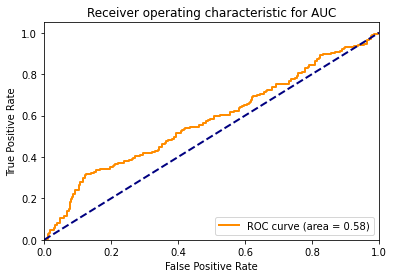

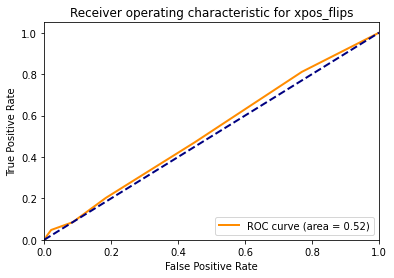

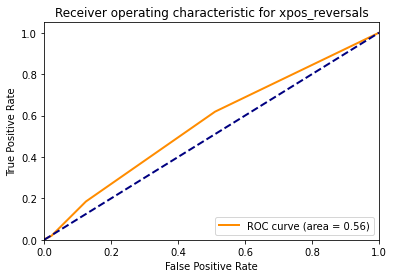

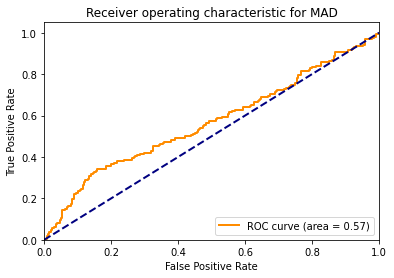

11


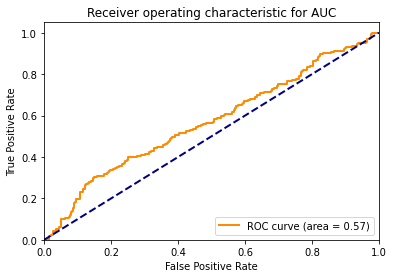

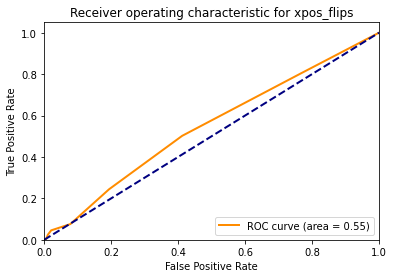

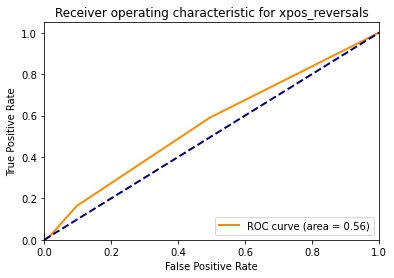

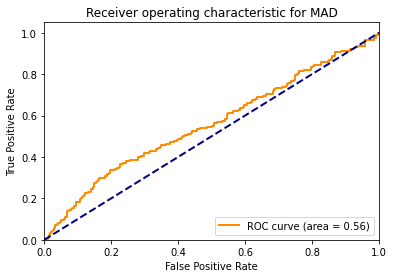

12


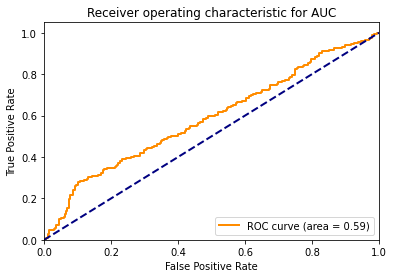

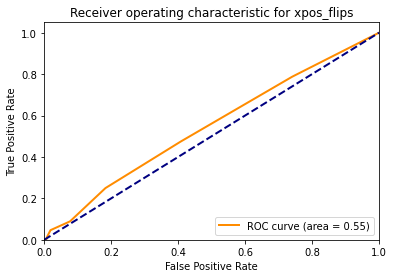

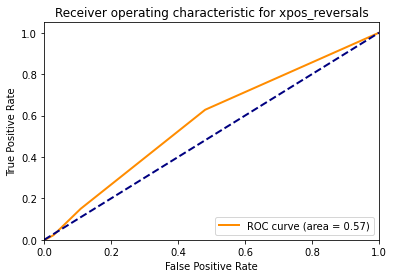

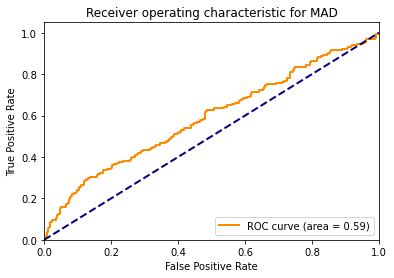

13


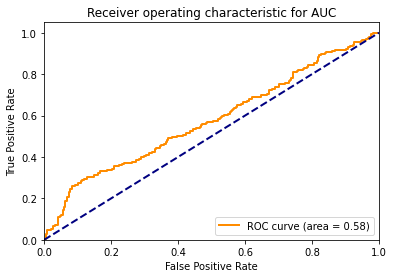

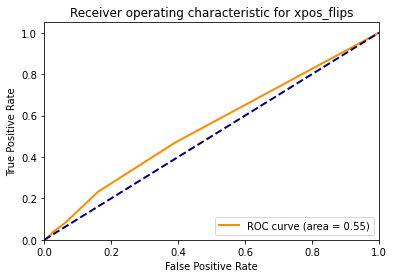

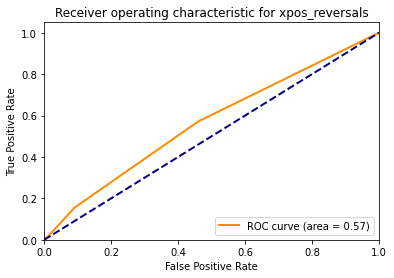

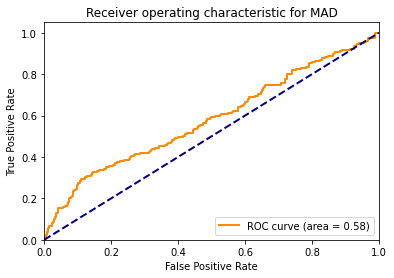

14


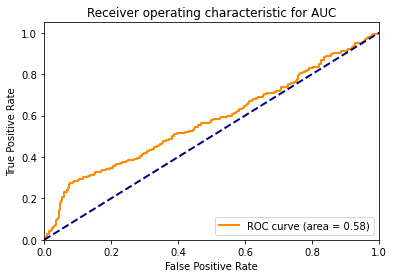

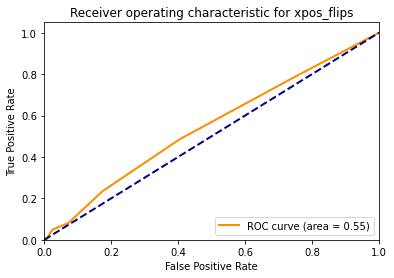

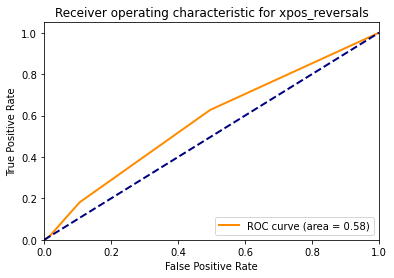

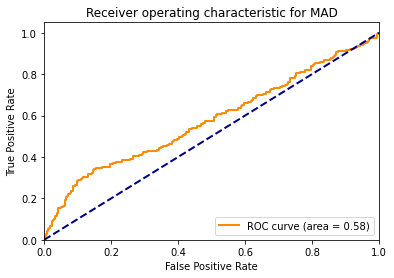

In [40]:
from sklearn.utils import resample


#Bootstrap / resample. 
subjects = np.unique(spivey_all_measures.loc[:,["Subject"]]) #Find all possible Subject values

def bootstuff():
    AUC_list = []
    xpos_flips_list = []
    xpos_reversals_list = []
    MAD_list = []
    full_LDA_list = []
    coord_LDA_list = []
    topline_list = []
    baseline_list = []
    n_subjects = []
    
    for i in range(5,len(subjects)):
        #Iteration and number of subjects
        i = i + 1
        n_subjects.append(i)
        #Subset and bootstrap for all measures
        spivey_sub_index = spivey_all_measures.loc[spivey_all_measures["Subject"].isin(subjects[0:i])].index.values
        spivey_sub = spivey_all_measures.iloc[spivey_sub_index,:]
        y_spivey2_sub = y_spivey2[spivey_sub_index]
      
        spivey_sub_boot, y_spivey2_sub_boot = resample(spivey_sub, y_spivey2_sub, n_samples= 2000, stratify= spivey_sub.loc[:,["Polarity"]])
        
        #START OF STATISICAL AUC TEST.
        print(i) #print iteration
        AUC_list.append(alternative_measures("AUC", data = spivey_sub_boot , labels= y_spivey2_sub_boot)) #AUC 

        xpos_flips_list.append(alternative_measures("xpos_flips", data = spivey_sub_boot , labels= y_spivey2_sub_boot)) #change of direction

        xpos_reversals_list.append(alternative_measures("xpos_reversals", data = spivey_sub_boot, labels= y_spivey2_sub_boot)) #Time it cross the y-axis. 

        MAD_list.append(alternative_measures("MAD",  data = spivey_sub_boot , labels= y_spivey2_sub_boot)) #Maximum absouloute deviation
        
        #LDA full
        X_spivey_sub = X_spivey.iloc[spivey_sub_index,:]
        X_spivey_sub_boot, y_spivey2_sub_boot_LDA = resample(X_spivey_sub, y_spivey2_sub, n_samples= 2000)


        full_LDA_list.append(train_test(n_compon= 13 , data_train= X, data_test = X_spivey_sub_boot, y_train= y_2, y_test = y_spivey2_sub_boot_LDA))

        #topline 
        topline_list.append(topline(n_compon= 13, data_train= X_spivey_sub_boot, y_train= y_spivey2_sub_boot_LDA))

        #baseline
        baseline_list.append(baseline(y_spivey2_sub_boot_LDA)[0])
        #LDA coords
        X_spivey_coord_sub = X_coord_spivey[spivey_sub_index,:]
        X_spivey_coord_sub_boot, y_spivey2_sub_coord_boot_LDA = resample(X_spivey_coord_sub, y_spivey2_sub, n_samples= 2000)

        coord_LDA_list.append(train_test(n_compon= 13 , data_train= X_coord, data_test= X_spivey_coord_sub_boot, y_train = y_2, y_test = y_spivey2_sub_coord_boot_LDA))


    final_auc_data = pd.DataFrame(
        {'n_subjects': n_subjects,
        'AUC_AUROC': AUC_list,
        'xpos_flips_AUROC': xpos_flips_list,
        'xpos_reversals_AUROC': xpos_reversals_list,
        'MAD_AUROC': MAD_list,
        'full_LDA_AUROC': full_LDA_list,
        'coord_LDA_AUROC': coord_LDA_list,
        'topline_AUROC': topline_list,
        'baseline_AUROC': baseline_list
        })
    return final_auc_data



auc_boot_models = bootstuff()


In [41]:
auc_boot_models

,n_subjects,AUC_AUROC,xpos_flips_AUROC,xpos_reversals_AUROC,MAD_AUROC,full_LDA_AUROC,coord_LDA_AUROC,topline_AUROC,baseline_AUROC
0,6,0.570330,0.540326,0.559559,0.559473,0.552398,0.542890,0.595531,0.500279
1,7,0.574864,0.545516,0.548559,0.563608,0.513138,0.518551,0.592299,0.499905
2,8,0.542676,0.534266,0.524092,0.533718,0.564776,0.546153,0.617368,0.500170
3,9,0.612358,0.560653,0.577174,0.611913,0.576928,0.551591,0.615166,0.499847
4,10,0.576422,0.522018,0.562081,0.566550,0.513036,0.535046,0.585601,0.500006
5,11,0.569713,0.545731,0.558691,0.558536,0.551907,0.544976,0.580401,0.500138
6,12,0.587364,0.545431,0.574530,0.590857,0.555788,0.584226,0.621110,0.500206
7,13,0.577871,0.546147,0.565349,0.582278,0.567078,0.542528,0.628536,0.500578
8,14,0.577134,0.546084,0.576819,0.578289,0.554536,0.599649,0.610633,0.499854


In [43]:
#mean and confidence intervals. 
mean = auc_boot_models.mean()

lower = auc_boot_models.mean() - auc_boot_models.sem()*1.96

upper = auc_boot_models.mean() + auc_boot_models.sem()*1.96



pd.DataFrame(np.row_stack((mean,lower,upper)))

,0,1,2,3,4,5,6,7,8
0,10.000000,0.576526,0.542908,0.560762,0.571691,0.549954,0.551734,0.605183,0.500109
1,8.210773,0.564664,0.536078,0.549832,0.557088,0.535302,0.535449,0.594024,0.499954
2,11.789227,0.588387,0.549738,0.571691,0.586294,0.564606,0.568020,0.616341,0.500264


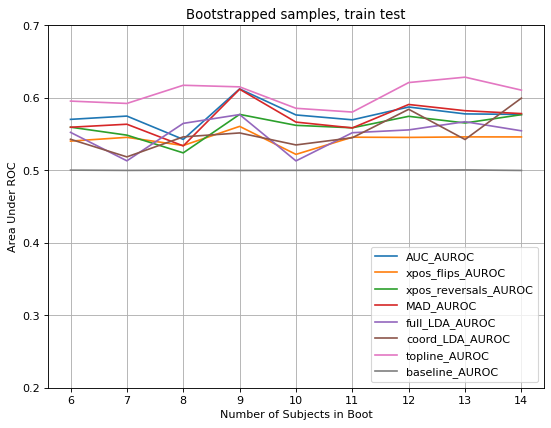

In [48]:
plt.figure(figsize=(8, 6), dpi=80)
for i in range(1,9):
    plt.plot(auc_boot_models.iloc[:,0], auc_boot_models.iloc[:,i], label = auc_boot_models.columns[i])
plt.legend(loc = "lower right")
plt.ylim(0.2,.7)
plt.ylabel("Area Under ROC")
plt.xlabel("Number of Subjects in Boot")
plt.title("Bootstrapped samples, train test")
plt.grid()
plt.savefig("train_test_bootstrapped_samples.png", dpi = 200)
plt.show()


# TIME FOR OTHER MODELS!! <3 <3 <3 <3 <3

In [ ]:
from sklearn.linear_model import LogisticRegression

def train_test_lr(n_compon, data_train , data_test, y_train, y_test):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    lr = LogisticRegression()

    #Standardize
    train_sc = sc.fit_transform(data_train)
    test_sc = sc.transform(data_test)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
    test_pc = pc.transform(test_sc)


    #lda
    lr.fit(train_pc, y_train)
    lr_score_y_test = lr.decision_function(test_pc)
    fpr, tpr, _  = roc_curve(y_test , lr_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score


train_test_lr(n_compon= 13, data_train= X, data_test= X_spivey, y_train= y_2, y_test= y_spivey2)




/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.554624182334307

In [ ]:
from sklearn import svm 
svm.SVC()
def train_test_svm(n_compon, data_train , data_test, y_train, y_test):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    sv = svm.SVC(kernel= "rbf", degree= 10, C = 2 )

    #Standardize
    train_sc = sc.fit_transform(data_train)
    test_sc = sc.transform(data_test)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
    test_pc = pc.transform(test_sc)


    #lda
    sv.fit(train_pc, y_train)
    sv_score_y_test = sv.decision_function(test_pc)
    fpr, tpr, _  = roc_curve(y_test , sv_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score


train_test_svm(n_compon= 13, data_train= X, data_test= X_spivey, y_train = y_2, y_test= y_spivey2)

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.5771614144073725

In [ ]:
print(train_test_svm(n_compon= 13, data_train= X_vel, data_test = X_vel_spivey, y_train= y_2 , y_test = y_spivey2))

print(train_test_svm(n_compon= 13, data_train= X_acc, data_test = X_acc_spivey, y_train= y_2 , y_test = y_spivey2))

print(train_test_svm(n_compon= 13, data_train= X_vel_acc, data_test = X_vel_acc_spivey, y_train= y_2 , y_test = y_spivey2))

0.5421174970173201
0.49787612621878474
0.5256407619204344
